## ensemble

In [1]:
# Ensemble - best between linear regression, random forest and XGBoost models

In [2]:
import pandas as pd
import numpy as np
import pickle

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, roc_curve, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import ensemble

from sklearn.ensemble import VotingClassifier

from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!

sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [4]:
df.dropna(axis=0, inplace=True)

In [5]:
# drop the row with "other" in gender as it is only one row
df = df[df.gender != 'Other']
df.gender.value_counts()

Female    2897
Male      2011
Name: gender, dtype: int64

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4908 non-null   int64  
 1   age                             4908 non-null   float64
 2   hypertension                    4908 non-null   int64  
 3   heart_disease                   4908 non-null   int64  
 4   avg_glucose_level               4908 non-null   float64
 5   bmi                             4908 non-null   float64
 6   stroke                          4908 non-null   int64  
 7   gender_Male                     4908 non-null   uint8  
 8   ever_married_Yes                4908 non-null   uint8  
 9   work_type_Never_worked          4908 non-null   uint8  
 10  work_type_Private               4908 non-null   uint8  
 11  work_type_Self-employed         4908 non-null   uint8  
 12  work_type_children              49

In [8]:
X = df.drop(columns=['stroke'], axis=1)
y = df.stroke

# stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [9]:
import imblearn.over_sampling

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# create 4x as many positive samples
ratio = {1 : n_pos * 4, 0 : n_neg}

# randomly oversample positives
ROS =imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio,random_state=42)
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)

In [10]:
lr_model = LogisticRegression(class_weight='balanced', solver='liblinear')
rf_model_logloss = RandomForestClassifier(n_jobs=-1 ,n_estimators=200, oob_score = True, class_weight={0:1,1:3}) 
rf_model_auc = RandomForestClassifier(n_jobs=-1 ,n_estimators=200, oob_score = True, class_weight={0:1,1:5}) 
XGB_model_auc = xgb.XGBClassifier( 
                               n_estimators=30000, 
                               max_depth=3,
                               objective="binary:logistic",  
                               learning_rate=.1, 
                               subsample=1,
                               min_child_weight=1,
                               colsample_bytree=.8,
                               scale_pos_weight=3,
                               use_label_encoder=False
                              )
XGB_model_logloss = xgb.XGBClassifier( 
                                   n_estimators=30000, 
                                   max_delta_step = 1,
                                   max_depth=4,
                                   objective="binary:logistic",
                                   learning_rate=.3, 
                                   subsample=1,
                                   min_child_weight=2,
                                   colsample_bytree=0.8,
                                   use_label_encoder=False,
                                   scale_pos_weight=2,
                                   gamma=0
                                  )

models = ["lr_model", "rf_model_logloss", "rf_model_auc", "XGB_model_auc", "XGB_model_logloss"]


## Train each model and save as pickle

In [26]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_tr_rs, y_tr_rs)
    
    with open(f"models/{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

[16:51:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614800145805/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614800145805/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
# Load pre-trained/tuned models

model_names = ["lr_model", "rf_model_logloss", "rf_model_auc", "XGB_model_auc", "XGB_model_logloss"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [28]:
model_list

[('lr_model', LogisticRegression(class_weight='balanced', solver='liblinear')),
 ('rf_model_logloss',
  RandomForestClassifier(class_weight={0: 1, 1: 3}, n_estimators=200, n_jobs=-1,
                         oob_score=True)),
 ('rf_model_auc',
  RandomForestClassifier(class_weight={0: 1, 1: 5}, n_estimators=200, n_jobs=-1,
                         oob_score=True)),
 ('XGB_model_auc',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.1, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=30000, n_jobs=8, num_parallel_tree=1, random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1,
                tree_method='exact', use_label_encoder=False,
                validate_paramete

In [29]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_model score: 0.7505091649694501
rf_model_logloss score: 0.9521384928716904
rf_model_auc score: 0.9541751527494908
XGB_model_auc score: 0.9470468431771895
XGB_model_logloss score: 0.9480651731160896


In [19]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(class_weight='balanced',
                                                 solver='liblinear')),
                             ('rf_model_logloss',
                              RandomForestClassifier(class_weight={0: 1, 1: 3},
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     oob_score=True)),
                             ('rf_model_auc',
                              RandomForestClassifier(class_weight={0: 1, 1: 5},
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     oob_score=True)),
                             ('XGB_model_auc',
                              XGBClassifie...
                                            gpu_id=-

In [20]:
y_pred = voting_classifer.predict(X_test)
print('accuracy', accuracy_score(y_test, y_pred))
print('Log_loss: ', log_loss(y_test, y_pred))
print('Precision : ', precision_score(y_test, y_pred))
print('Recall : ', recall_score(y_test, y_pred))

accuracy 0.9501018329938901
Log_loss:  1.723428146771961
Precision :  0.1111111111111111
Recall :  0.023809523809523808


In [21]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

probas = voting_classifer.predict_proba(X_test)[:,1]
print('auc_score', roc_auc_score(y_test,probas))

y_pred = voting_classifer.predict(X_test)
print('accuracy', accuracy_score(y_test, y_pred))
print('Log_loss: ', log_loss(y_test, y_pred))
print('Precision : ', precision_score(y_test, y_pred))
print('Recall : ', recall_score(y_test, y_pred))

auc_score 0.7876899696048631
accuracy 0.9511201629327902
Log_loss:  1.6882562767160438
Precision :  0.2
Recall :  0.047619047619047616


## Voting for models trained on data which is not oversampled

In [25]:
# best auc score
lr_6x = LogisticRegression(C=100, class_weight={1 : 6, 0 : 1}, solver='liblinear') 

# best logloss
lr_4x = LogisticRegression(C=100, class_weight={1 : 4, 0 : 1}, solver='liblinear') 


In [34]:
models = ['lr_6x', 'lr_4x']

for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"models/{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

In [35]:
model_names = ["lr_6x", "lr_4x"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [36]:
model_list

[('lr_6x',
  LogisticRegression(C=100, class_weight={0: 1, 1: 6}, solver='liblinear')),
 ('lr_4x',
  LogisticRegression(C=100, class_weight={0: 1, 1: 4}, solver='liblinear'))]

In [37]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_6x score: 0.8961303462321792
lr_4x score: 0.9276985743380856


In [38]:
# create voting classifier - average
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

probas = voting_classifer.predict_proba(X_test)[:,1]
print('auc_score', roc_auc_score(y_test,probas))

y_pred = voting_classifer.predict(X_test)
print('accuracy', accuracy_score(y_test, y_pred))
print('Log_loss: ', log_loss(y_test, y_pred))
print('Precision : ', precision_score(y_test, y_pred))
print('Recall : ', recall_score(y_test, y_pred))

auc_score 0.7924265450861195
accuracy 0.929735234215886
Log_loss:  2.426889975510372
Precision :  0.22448979591836735
Recall :  0.2619047619047619


In [39]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no_stroke', 'stroke'],
           yticklabels=['no_stroke', 'stroke']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

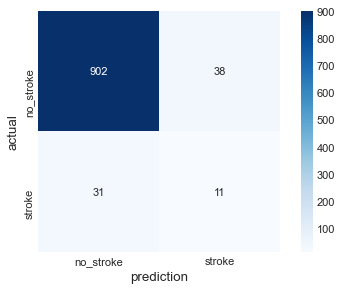

In [40]:
make_confusion_matrix(voting_classifer)

In [42]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(voting_classifer, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [43]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = voting_classifer.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f}, Recall: {:6.4f}".format(precision_score(y_test, y_predict), recall_score(y_test, y_predict)))


Default threshold:
Precision: 0.2245, Recall: 0.2619


In [44]:
# using the default threshold of 0.06, which is what vanilla predict does
y_predict = voting_classifer.predict_proba(X_test)[:,1] > 0.06
print("Default threshold of 0.06:")
print("Precision: {:6.4f}, Recall: {:6.4f}".format(precision_score(y_test, y_predict), recall_score(y_test, y_predict)))


Default threshold of 0.06:
Precision: 0.0650, Recall: 0.9762


In [45]:
# using the default threshold of 0.08, which is what vanilla predict does
y_predict = voting_classifer.predict_proba(X_test)[:,1] > 0.08
print("Default threshold of 0.08:")
print("Precision: {:6.4f}, Recall: {:6.4f}".format(precision_score(y_test, y_predict), recall_score(y_test, y_predict)))


Default threshold of 0.08:
Precision: 0.0756, Recall: 0.9524


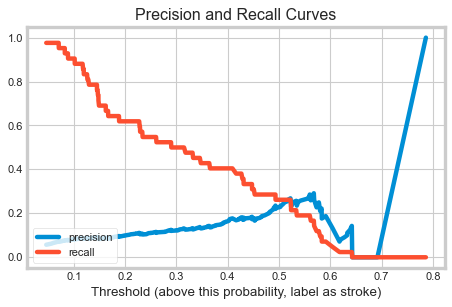

In [46]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, voting_classifer.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as stroke)');
plt.title('Precision and Recall Curves');

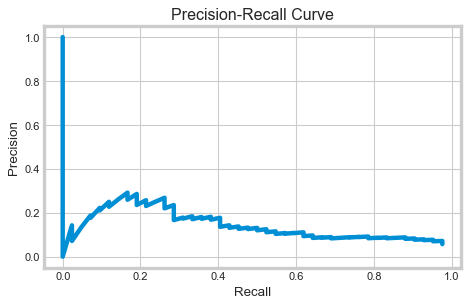

In [47]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [48]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, voting_classifer.predict_proba(X_test)[:,1])

ROC AUC score =  0.7924265450861195


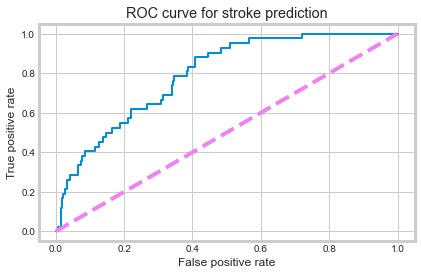

In [50]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for stroke prediction');
print("ROC AUC score = ", roc_auc_score(y_test, voting_classifer.predict_proba(X_test)[:,1]))